## Raster data to Vector

This notebook processes the [World Pop age and sex disaggregated School Age population raster data](https://hub.worldpop.org/geodata/listing?id=94) to Vector form for easier use in TS environments. This requires using the libraries `rasterio` and `rioxarray` to read in the raster files and save out a GeoJSON with the population counts at the centroid of each gridcell. These libraries are not available by default in `res_latest` kernel and hence requires [creating a custom nest environment](https://doc.app.twosigma.com/doc/ts_lang_python_virtualenv/python/) in your IRE. By default nest environments are located in your `nas/` directory and will get picked up as a kernel option on BeakerX Lab. 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [2]:
#!pip install rasterio

In [280]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.io import MemoryFile
import rioxarray as rx
from beakerx import *
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
# The following parameter will help make our visualizations a bit larger than the default
plt.rcParams['figure.figsize'] = (10,10) 
import warnings
warnings.filterwarnings('ignore')

In [181]:
african_countries = pd.read_excel('../data/raw/african_countries.xlsx')

In [276]:
def write_geojson_to_ts3(df, country):
    df.to_file(f"../data/processed/child_population.geojson",driver="GeoJSON")

In [249]:
def get_cell_areas(raster):
    testif = raster.rio
    # rast = testif.read(1)
    gt = testif.transform()
    pix_width = gt[0]
    ulX = gt[2]
    ulY = gt[5]
    rows = testif.height
    cols = testif.width
    lrX = ulX + gt[0] * cols
    lrY = ulY + gt[4] * rows

    lats = np.linspace(ulY,lrY,rows+1)

    a = 6378137
    b = 6356752.3142

    # Degrees to radians
    lats = lats * np.pi/180

    # Intermediate vars
    e = np.sqrt(1-(b/a)**2)
    sinlats = np.sin(lats)
    zm = 1 - e * sinlats
    zp = 1 + e * sinlats

    # Distance between meridians
    #        q = np.diff(longs)/360
    q = pix_width/360

    # Compute areas for each latitude in square km
    areas_to_equator = np.pi * b**2 * ((2*np.arctanh(e*sinlats) / (2*e) + sinlats / (zp*zm))) / 10**6
    areas_between_lats = np.diff(areas_to_equator)
    areas_cells = np.abs(areas_between_lats) * q

    areagrid = np.transpose(np.matlib.repmat(areas_cells,cols,1))

In [284]:
countries = african_countries.Abbreviation
genders = ['F_M']
levels = ['PRIMARY','SECONDARY']

In [286]:
# pop_dfs = []
## Loop through countries
## Edit path to load raster data
for country in countries:
    i=0
    for gender in genders:
        for level in levels:
            try:
                print(f" Loading data for {country} - {gender} - {level}")
                raster =  rx.open_rasterio(filename="../data/raw/POPULATION/{country}_SAP_1km_2020/{country}_{gender}_{level}_2020_1km.tif")
                band = raster[0]

                if (i==0):
                    x, y, intensity = band.x.values, band.y.values, band.values
                    x, y = np.meshgrid(x, y)
                    x, y, intensity = x.flatten(), y.flatten(), intensity.flatten().astype(float)
                    centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs="epsg:4326"))
                    centroids['pop_children_total'] = 0
                else:
                    intensity = band.values.flatten().astype(float)

                centroids[f'pop_{gender}_{level}'] = intensity
                centroids['pop_children_total'] = centroids['pop_children_total'] + centroids[f'pop_{gender}_{level}']
                i = i+1
            except:
                pass
            # pop_dfs.append(centroids)
    ## Write file back
    centroids = centroids[centroids[f'pop_{gender}_{level}']>0]
    print(f"Writing file for {country}")
    write_geojson_to_ts3(centroids, country)
    

 Loading data for SHN - F_M - PRIMARY
 Loading data for SHN - F_M - SECONDARY
Writing file for SHN
 Loading data for STP - F_M - PRIMARY


 Loading data for STP - F_M - SECONDARY
Writing file for STP


 Loading data for SEN - F_M - PRIMARY


 Loading data for SEN - F_M - SECONDARY


Writing file for SEN
 Loading data for SYC - F_M - PRIMARY


 Loading data for SYC - F_M - SECONDARY


Writing file for SYC
 Loading data for SLE - F_M - PRIMARY


 Loading data for SLE - F_M - SECONDARY


Writing file for SLE
 Loading data for SOM - F_M - PRIMARY


 Loading data for SOM - F_M - SECONDARY


Writing file for SOM
 Loading data for ZAF - F_M - PRIMARY


 Loading data for ZAF - F_M - SECONDARY


Writing file for ZAF
 Loading data for SSD - F_M - PRIMARY


 Loading data for SSD - F_M - SECONDARY


Writing file for SSD
 Loading data for SDN - F_M - PRIMARY


 Loading data for SDN - F_M - SECONDARY


Writing file for SDN
 Loading data for TZA - F_M - PRIMARY


 Loading data for TZA - F_M - SECONDARY


Writing file for TZA
 Loading data for TGO - F_M - PRIMARY


 Loading data for TGO - F_M - SECONDARY


Writing file for TGO
 Loading data for TUN - F_M - PRIMARY


 Loading data for TUN - F_M - SECONDARY


Writing file for TUN
 Loading data for UGA - F_M - PRIMARY


 Loading data for UGA - F_M - SECONDARY


Writing file for UGA
 Loading data for ZMB - F_M - PRIMARY


 Loading data for ZMB - F_M - SECONDARY


Writing file for ZMB
 Loading data for ZWE - F_M - PRIMARY


 Loading data for ZWE - F_M - SECONDARY


Writing file for ZWE


In [321]:
centroids.pop_children_total.describe()

count    479646.000000
mean          9.450261
std          38.053304
min           0.007632
25%           2.161092
50%           4.418361
75%           8.568791
max        2007.023315
Name: pop_children_total, dtype: float64

In [317]:
## Population distribution is highly skewed towards urban centres and hence plotting the log transform is provides a clearer view of the data
centroids['pop_children_total_log'] = np.log10(centroids.pop_children_total)

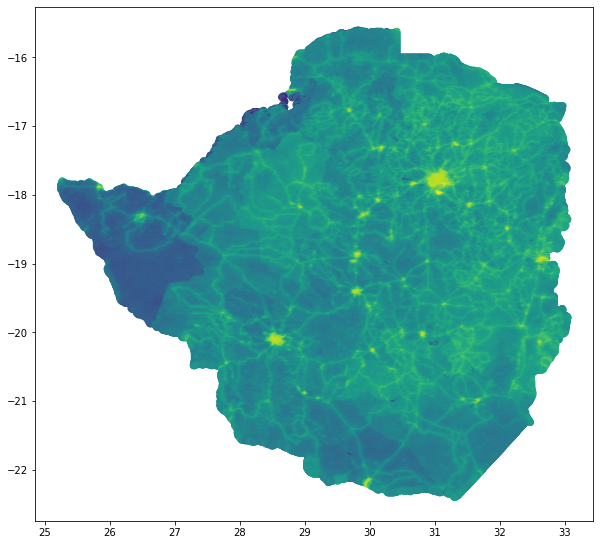

In [323]:
centroids.plot(column='pop_children_total_log')

In [314]:
centroids.pop_children_total.sum()

4532780.12542258